In [152]:
import json
import pandas as pd
rows = []
for task in ["NER", "NLI", "POS"]:
    with open(f"output/{task}_pretrained_hyperparameter_search.json", "r") as f:
        ner = json.load(f)
        f.close()
    base={}
    for language in ner:
        
        for model in ner[language]:
            if language == "language_en_done":
                rows.append([task, model, "base", ner[language][model]["0.0"], 0.0, 0])
                base[model] =  ner[language][model]["0.0"]
            else:
                score = max(ner[language][model].values())
                delta = base[model] - score
                rows.append([task, model, language.split("_")[1], max(ner[language][model].values()), float(max(ner[language][model], key=ner[language][model].get)), delta])
with open(f"output/DP_pretrained_hyperparameter_search.json", "r") as f:
    dp = json.load(f)
    f.close()
base={}
for language in dp:
    
    for model in dp[language]:
        if language == "language_en_done":
            rows.append(["DP", model, "base", dp[language][model]["0.0"]["uas"]/100, 0.0])
            base[model] =  dp[language][model]["0.0"]["uas"] / 100
        else:
            values = {key: val["uas"] for key, val in dp[language][model].items()}
            score = max(values.values()) / 100
            delta = base[model] - score
            rows.append(["DP", model, language.split("_")[1], score, float(max(values, key=values.get)), delta])
df = pd.DataFrame(rows, columns = ["task", "model", "language", "score", "lambda", "delta"])
df

,task,model,language,score,lambda,delta
0,NER,bert,base,0.952263,0.0,0.000000
1,NER,roberta,base,0.948735,0.0,0.000000
2,NER,bert,es,0.928020,0.9,0.024243
3,NER,roberta,es,0.918660,0.9,0.030075
4,NER,bert,hi,0.888413,0.9,0.063850
5,NER,roberta,hi,0.908786,0.7,0.039950
6,NER,bert,de,0.877233,0.6,0.075030
7,NER,roberta,de,0.882565,1.0,0.066171
8,NER,bert,zh,0.845494,0.8,0.106769
9,NER,roberta,zh,0.677097,0.2,0.271638


/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/305518911.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/305518911.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/305518911.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/305518911.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

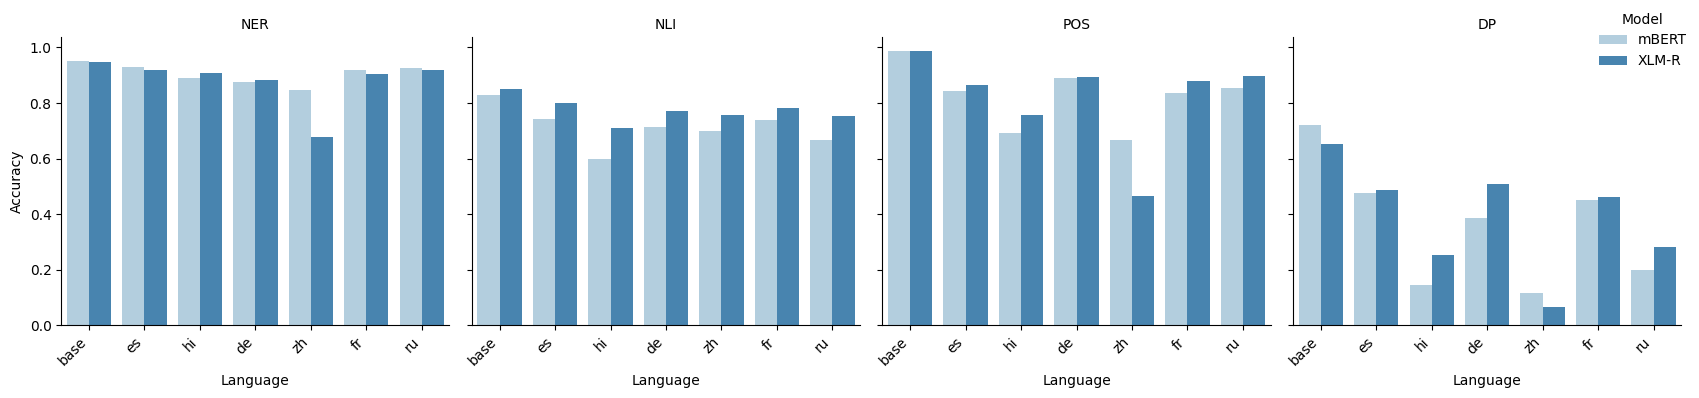

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



# --- Create a FacetGrid with 4 subplots, one for each task ---
g = sns.FacetGrid(
    df,
    col="task",
    col_wrap=4,  
    sharey=True,    
    sharex=False, 
    height=4,
)

# --- Map a grouped barplot onto each facet ---
g.map_dataframe(
    sns.barplot,
    x="language",
    y="score",
    hue="model",
    palette="Blues"
)

# --- Customize ---
g.add_legend(title="Model", loc="upper right")
g.set_axis_labels("Language", "Accuracy")
g.set_titles("{col_name}")
for t, l in zip(g._legend.texts, ["mBERT", "XLM-R"]):
    t.set_text(l)
# Make x labels readable
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/1364675993.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/1364675993.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/1364675993.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/1364675993.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

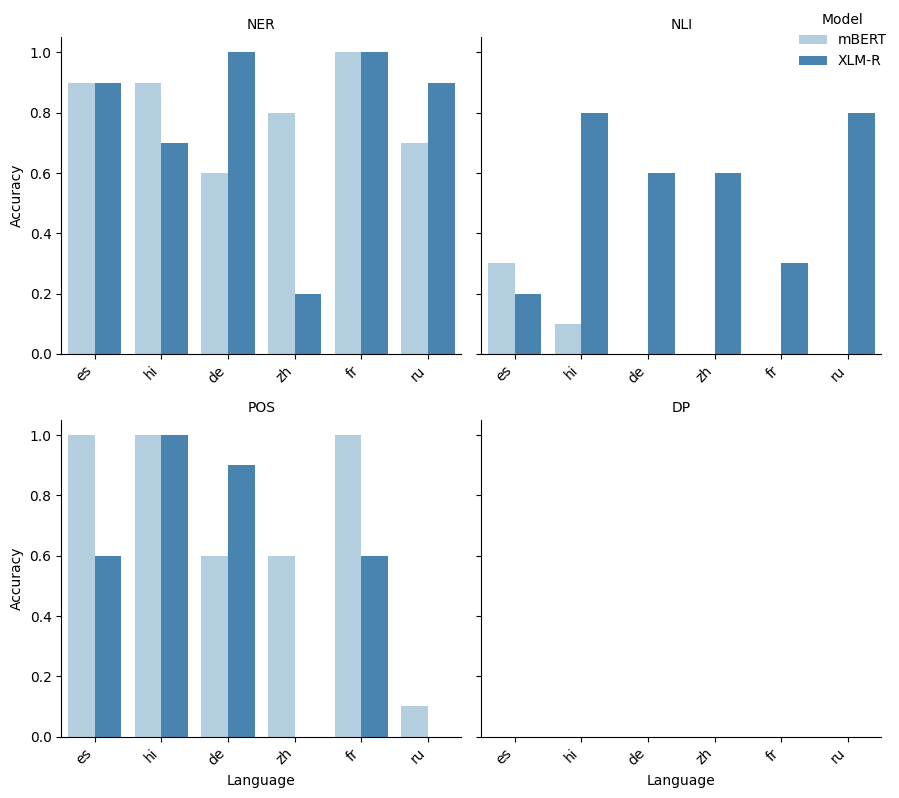

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



# --- Create a FacetGrid with 4 subplots, one for each task ---
g = sns.FacetGrid(
    df[df['language'] != 'base'],
    col="task",
    col_wrap=2,  
    sharey=True,    
    sharex=False, 
    height=4,
)

# --- Map a grouped barplot onto each facet ---
g.map_dataframe(
    sns.barplot,
    x="language",
    y="lambda",
    hue="model",
    palette="Blues"
)

# --- Customize ---
g.add_legend(title="Model", loc="upper right")
g.set_axis_labels("Language", "Accuracy")
g.set_titles("{col_name}")
for t, l in zip(g._legend.texts, ["mBERT", "XLM-R"]):
    t.set_text(l)
# Make x labels readable
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [157]:
df

,task,model,language,score,lambda,delta
0,NER,bert,base,0.952263,0.0,0.000000
1,NER,roberta,base,0.948735,0.0,0.000000
2,NER,bert,es,0.928020,0.9,0.024243
3,NER,roberta,es,0.918660,0.9,0.030075
4,NER,bert,hi,0.888413,0.9,0.063850
5,NER,roberta,hi,0.908786,0.7,0.039950
6,NER,bert,de,0.877233,0.6,0.075030
7,NER,roberta,de,0.882565,1.0,0.066171
8,NER,bert,zh,0.845494,0.8,0.106769
9,NER,roberta,zh,0.677097,0.2,0.271638


/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/2434042627.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/2434042627.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/2434042627.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/2434042627.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

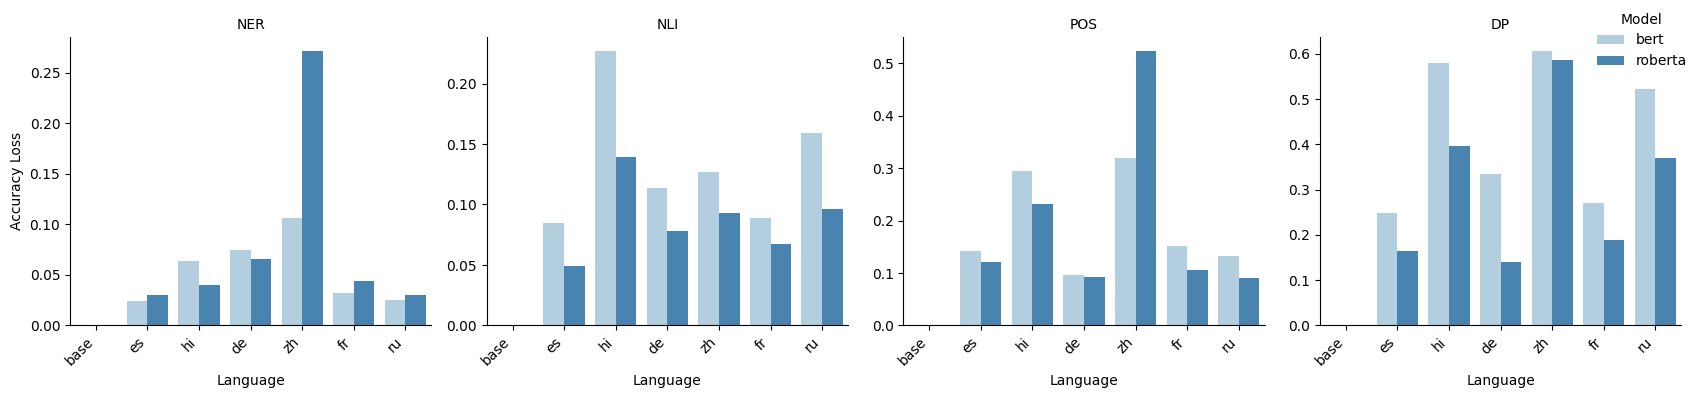

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



# --- Create a FacetGrid with 4 subplots, one for each task ---
g = sns.FacetGrid(
    df,
    col="task",
    col_wrap=4,            # ensures 4 side-by-side
    sharey=False,          # scores for DP differ in scale
    height=4
)

# --- Map a grouped barplot onto each facet ---
g.map_dataframe(
    sns.barplot,
    x="language",
    y="delta",
    hue="model",
    palette="Blues"
)

# --- Customize ---
g.add_legend(title="Model", loc="upper right")
g.set_axis_labels("Language", "Accuracy Loss")
g.set_titles("{col_name}")

# Make x labels readable
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Model: XLM-R
  Spearman rho = -0.594, p = 0.0418

Model: mBERT
  Spearman rho = -0.594, p = 0.0418



/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/1678055063.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/1678055063.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


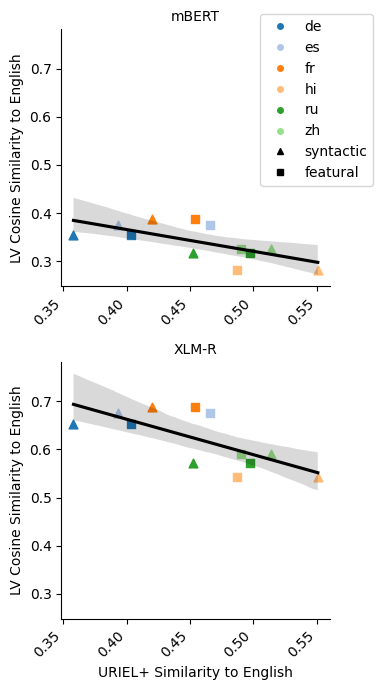

In [ ]:
from scipy.stats import spearmanr, pearsonr

# cosine similarity vs tv cosine similarity. 
with open("output/languages/uriel_plus.json", "r") as f:
    uriel = json.load(f)
    f.close()
df2 = pd.read_csv("output/languages/english_cosims.csv")
df2["model"] = df2["model"].replace({
    "bert": "mBERT",
    "roberta": "XLM-R",

})
uriel_rows = []
for k in[ "syntactic", "featural"]:
    uriel_rows += [[key, val, k] for key, val in uriel[k].items()]

df3 = pd.DataFrame(uriel_rows, columns=["language", "uriel", "type"] )
# Merge df2 into df1 on the 'key' column
df2 = pd.merge(df2, df3, on='language', how="right")
correlations = {}
for model_name, subdf in df2.groupby("model"):
    rho, p = spearmanr(subdf["uriel"], subdf["en_cossim"])#, nan_policy="omit")
    correlations[model_name] = (rho, p)
    print(f"Model: {model_name}")
    print(f"  Spearman rho = {rho:.3f}, p = {p:.3g}")
    print()
    
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# ----------------------------------------------------------
# Marker shapes by type (always black)
# ----------------------------------------------------------
marker_map = {
    "syntactic": "^",
    "featural": "s"
}

# ----------------------------------------------------------
# Colors by language
# ----------------------------------------------------------
languages = sorted(df2["language"].unique())
palette = sns.color_palette("tab20", len(languages))
color_map = dict(zip(languages, palette))


def reg_with_labels(data, **kwargs):

    # Plot each point manually
    for _, row in data.iterrows():
        plt.scatter(
            row["uriel"],
            row["en_cossim"],
            s=40,
            marker=marker_map[row["type"]],
            color=color_map[row["language"]]
        )

    # regression line
    sns.regplot(
        data=data,
        x="uriel",
        y="en_cossim",
        scatter=False,
        color="black"
    )


# ----------------------------------------------------------
# FacetGrid
# ----------------------------------------------------------
g = sns.FacetGrid(
    df2,
    col="model",
    col_wrap=1,
    sharex=False,
    height=3.5,

)
g.map_dataframe(reg_with_labels)

g.set_axis_labels("URIEL+ Similarity to English", "LV Cosine Similarity to English")
g.set_titles("{col_name}")

for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# ----------------------------------------------------------
# ONE LEGEND BOX: types (black shapes) + languages (colored dots)
# ----------------------------------------------------------

legend_handles = []



# ---------- Section 2: LANGUAGES (colored dots) ----------
for lang in languages:
    legend_handles.append(
        mlines.Line2D(
            [], [],
            marker='o',
            color=color_map[lang],
            linestyle='None',
            markersize=4,
            label=f"{lang}"
        )
    )
    # ---------- Section 1: TYPE (black shapes) ----------
for type_name, marker in marker_map.items():
    legend_handles.append(
        mlines.Line2D(
            [], [], 
            marker=marker,
            color="black",
            linestyle='None',
            markersize=4,
            label=f"{type_name}"
        )
    )

# Add ONE unified legend box
g.fig.legend(
    handles=legend_handles,
    loc="center right",
    bbox_to_anchor=(1.1, 0.85),
)

plt.tight_layout()
plt.show()


   task    model language     score lambda     delta
0   NER     bert     base  0.952263    0.0  0.000000
1   NER  roberta     base  0.948735    0.0  0.000000
2   NER     bert       es  0.928020    0.9  0.024243
3   NER  roberta       es  0.918660    0.9  0.030075
4   NER     bert       hi  0.888413    0.9  0.063850
5   NER  roberta       hi  0.908786    0.7  0.039950
6   NER     bert       de  0.877233    0.6  0.075030
7   NER  roberta       de  0.882565    1.0  0.066171
8   NER     bert       zh  0.845494    0.8  0.106769
9   NER  roberta       zh  0.677097    0.2  0.271638
10  NER     bert       fr  0.920073    1.0  0.032190
11  NER  roberta       fr  0.905145    1.0  0.043591
12  NER     bert       ru  0.926936    0.7  0.025327
13  NER  roberta       ru  0.918974    0.9  0.029761
14  NLI     bert     base  0.827309    0.0  0.000000
15  NLI  roberta     base  0.849398    0.0  0.000000
16  NLI     bert       es  0.742570    0.3  0.084739
17  NLI  roberta       es  0.800402    0.2  0.

/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/2547666484.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/2547666484.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/2547666484.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/v3/_lv5rwjn5j3f4mqdly_xvvg00000gn/T/ipykernel_28568/2547666484.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

Model: DP
  Spearman rho = -0.629, p = 0.0283

Model: NER
  Spearman rho = 0.035, p = 0.914

Model: NLI
  Spearman rho = -0.832, p = 0.000785

Model: POS
  Spearman rho = -0.385, p = 0.217



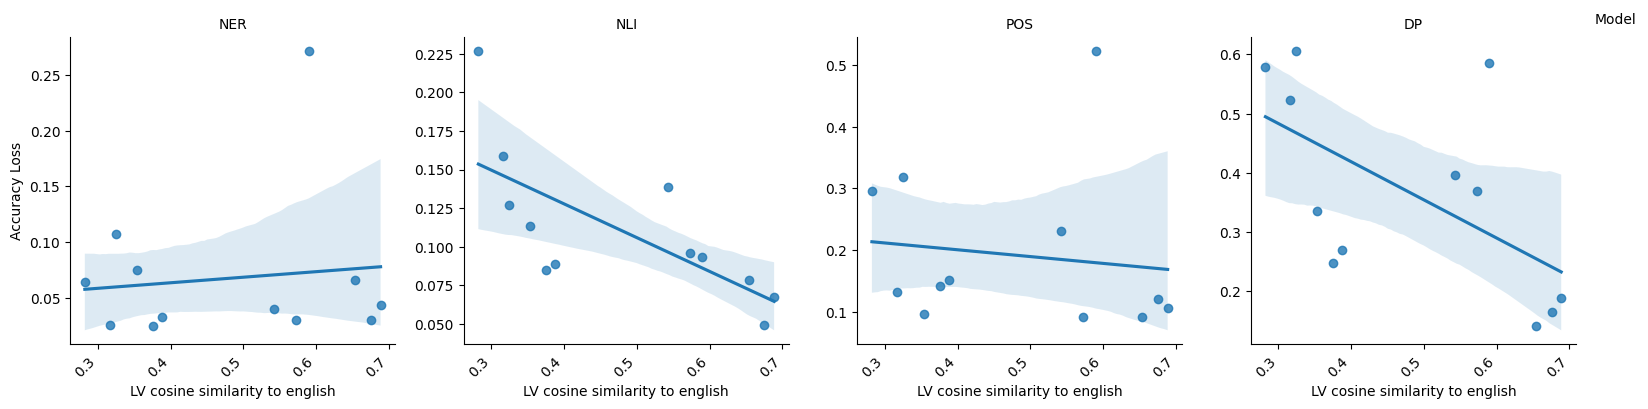

In [ ]:
# correlation cosine similarity vs accuracy loss?? 
df2 = pd.read_csv("output/languages/english_cosims.csv")

df4 = pd.merge(df, df2, on=["model", "language"], how="right")
print(df, df2)
# --- Create a FacetGrid with 4 subplots, one for each task ---
g = sns.FacetGrid(
    df4,
    col="task",
    col_wrap=4,            # ensures 4 side-by-side
    sharey=False,          # scores for DP differ in scale
    height=4
)

# --- Map a grouped barplot onto each facet ---
g.map_dataframe(
    sns.regplot,
    x="en_cossim",
    y="delta",
    # hue="model",
    # palette="Blues"
)

# --- Customize ---
g.add_legend(title="Model", loc="upper right")
g.set_axis_labels("LV cosine similarity to english", "Accuracy Loss")
g.set_titles("{col_name}")

# Make x labels readable
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for model_name, subdf in df4.groupby("task"):
    rho, p = spearmanr(subdf["en_cossim"], subdf["delta"])#, nan_policy="omit")
    correlations[model_name] = (rho, p)
    print(f"Model: {model_name}")
    print(f"  Spearman rho = {rho:.3f}, p = {p:.3g}")
    print()
# plt.tight_layout()
plt.show()

      model language  en_cossim
0      bert       es   0.375214
1      bert       de   0.353476
2      bert       hi   0.282100
3      bert       zh   0.324346
4      bert       fr   0.387685
5      bert       ru   0.316349
6   roberta       es   0.675551
7   roberta       de   0.653719
8   roberta       hi   0.542270
9   roberta       zh   0.590074
10  roberta       fr   0.688862
11  roberta       ru   0.572688
   task    model language     score lambda     delta    uriel  en_cossim
0   NER     bert       es  0.928020    0.9  0.024243  0.42990   0.375214
1   NLI     bert       es  0.742570    0.3  0.084739  0.42990   0.375214
2   POS     bert       es  0.843877    1.0  0.141881  0.42990   0.375214
3    DP     bert       es  0.475080    0.0  0.247381  0.42990   0.375214
4   NER  roberta       es  0.918660    0.9  0.030075  0.42990   0.675551
5   NLI  roberta       es  0.800402    0.2  0.048996  0.42990   0.675551
6   POS  roberta       es  0.866022    0.6  0.121028  0.42990   0.675551


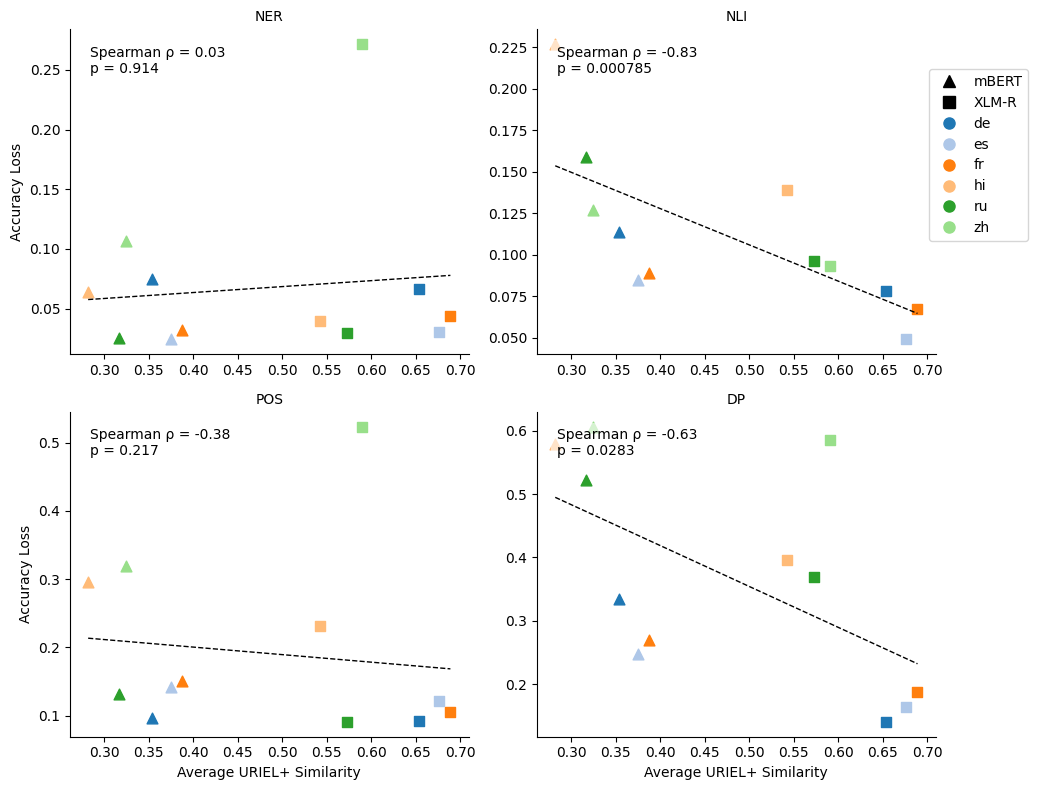

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from matplotlib.lines import Line2D
import numpy as np
# cosine similarity vs tv cosine similarity. 
with open("output/languages/uriel_plus.json", "r") as f:
    uriel = json.load(f)
    f.close()
df2 = pd.read_csv("output/languages/english_cosims.csv")
print(df2)

uriel_langs = {}
for k in["syntactic", "featural"]:
    for lang, val in uriel[k].items():
        if lang not in uriel_langs:
            uriel_langs[lang] = [val]
        else:
            uriel_langs[lang].append(val)
uriel_rows = [[lang, np.mean(val)] for lang, val in uriel_langs.items()]
df3 = pd.DataFrame(uriel_rows, columns=["language", "uriel"] )
df3 = pd.merge(df3, df2, on="language")
# Merge df2 into df1 on the 'key' column
df4 = pd.merge(df, df3, on=['language', 'model'], how="right")
print(df4)
languages = sorted(df4["language"].unique())
models = sorted(df4["model"].unique())
# Marker shapes per model
marker_map = {
    "bert": "^",
    "roberta": "s"
}
color_map = dict(zip(languages, sns.color_palette("tab20", len(languages))))


def one_regline_language_color_model_marker(data, x, y, hue_lang, style_model, **kwargs):
    ax = plt.gca()

    # --- unique languages (colors) and models (markers) ---
    languages = sorted(data[hue_lang].unique())
    models = sorted(data[style_model].unique())

    # color palette for languages
    colors = sns.color_palette("tab20", len(languages))
    color_map = dict(zip(languages, colors))

    # --- scatter points ---
    for lang in languages:
        for model in models:
            sub = data[(data[hue_lang] == lang) & (data[style_model] == model)]
            if sub.empty:
                continue

            ax.scatter(
                sub[x], sub[y],
                color=color_map[lang],
                marker=marker_map[model],
                s=60,
                label=f"{lang} ({model})"  # legend cleaned later
            )

    # --- ONE regression line across ALL data ---
    sns.regplot(
        data=data,
        x=x, y=y,
        scatter=False,
        ci=None,
        color="black",
        line_kws={"linewidth": 1.0, "linestyle": "--"},
        ax=ax
    )

    # --- Spearman correlation ---
    rho, p = spearmanr(data[x], data[y])
    ax.text(
        0.05, 0.95,
        f"Spearman ρ = {rho:.2f}\np = {p:.3g}",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )
    ax.set_xlabel("URIEL+ Syntactic Distance From English")


# --- FacetGrid ---
g = sns.FacetGrid(
    df4,
    col="task",
    col_wrap=2,
    sharey=False,
    sharex=False,
    height=4,
)

# --- map our function: language → color, model → shape ---
g.map_dataframe(
    one_regline_language_color_model_marker,
    x="en_cossim",
    y="delta",
    hue_lang="language",
    style_model="model"
)

# from matplotlib.lines import Line2D

# # -----------------------
# # MODEL LEGEND (TOP)
# # -----------------------
# Force desired display names:
model_display_names = {
    "bert": "mBERT",
    "roberta": "XLM-R",
}
# model_elements = [
#     Line2D([0], [0],
#            marker=marker_map[m],
#            linestyle='',
#            color='black',
#            markersize=6,
#            label=model_display_names[m])
#     for m in models
# ]
# ----------------------------------------------------------
# ONE LEGEND BOX: types (black shapes) + languages (colored dots)
# ----------------------------------------------------------

legend_handles = []

# ---------- Section 1: TYPE (black shapes) ----------
for type_name, marker in marker_map.items():
    legend_handles.append(
        mlines.Line2D(
            [], [], 
            marker=marker,
            color="black",
            linestyle='None',
            markersize=8,
            label=model_display_names[type_name]
        )
    )

# ---------- Section 2: LANGUAGES (colored dots) ----------
for lang in languages:
    legend_handles.append(
        mlines.Line2D(
            [], [],
            marker='o',
            color=color_map[lang],
            linestyle='None',
            markersize=8,
            label=f"{lang}"
        )
    )
g.set_titles("{col_name}")

# Add ONE unified legend box
g.fig.legend(
    handles=legend_handles,
    loc="center right",
    bbox_to_anchor=(1.3, 0.8),
)
g.set_axis_labels("Average URIEL+ Similarity", "Accuracy Loss")
plt.tight_layout()

plt.tight_layout(rect=[0, 0, 1.2, 1])  # leaves 20% of figure width on right

